## Author: Isha Nayak
## Last Modified: September 15
## The purpose of this notebook is to check if you input either a flat point source or flat extended source, then the output is also flat. We check the flatness of a source by inputting a known flat source, then checking the output three different ways: (1) our own code which sums up the total flux, (2) the cube build algorithm, and (3) extract 1D algorithm. We want to make sure nothing strange is happening during the cube build and extract 1D steps.

In [1]:
# Check jwst pipeline version
import jwst
jwst.__version__

'0.18.3'

In [2]:
#Import inject psf
import miri3d.tools.inject_psf as ip

#Import assign wcs
from jwst.assign_wcs import AssignWcsStep

#Import modshep
import miri3d.modshep.modshep as modshep

#Import plotting things
import matplotlib.pyplot as plt

#Import fits file things
from astropy.io import fits

#Import cube build
from jwst.cube_build import CubeBuildStep

#Import extract1D
from jwst.extract_1d import Extract1dStep

#Import table
from astropy.table import Table

import sys
from ci_watson.artifactory_helpers import get_bigdata

#### Run the inject_psf code for point source with the following:
#### ip.main('12A',[1,2],1,1e-7)
#### This would give a standard 2-pt dither in Ch12A with a specified PSF total (total=1) and background/extended value (1e-7).
#### Run the inject_psf code for extended source with the following:
#### inject_psf.main('12A',[1,2,3,4],0,1)
#### This would give a standard 2-pt dither in Ch12A with no specified PSF and an extended source with flat spectrum of 1.
#### The output should be two scene files, two mock files, and two mockarea files.

In [3]:
# Read association file in from artifactory

asnfile = get_bigdata('jwst_validation_notebooks',
                      'validation_data',
                      'cube_build',
                      'cube_build_miri_test',
                      'cube_testing.json')


In [4]:
#Define band and channels
band_chan=['12A','34A','12B','34B','12C','34C']

#Define Channels 1 and 3
indiv1=['1A','3A','1B','3B','1C','3C']

#Define Channels 2 and 4
indiv2=['2A','4A','2B','4B','2C','4C']

#Define plot colors for each band
plot_color=['black','black','blue','blue','red','red']

#### Using D. Law's injest_psf code to first define a flat point source or flat extended source in a particular band/channel which does not depend on JWST pipeline for distortion transforms. Then this uses D. Law's modshep code as a standalone implementation of modified Sheperd's cube building algorithm. We need to correct units and plot the output from the modshep algorithm.



Setting up the dithers
Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2021-02-04 17:07:35,325 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 17:07:35,414 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12A-0.fits',).


2021-02-04 17:07:35,415 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 17:07:38,794 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 17:07:40,764 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 17:07:40,835 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999131306 -0.000874755 45.000333171 -0.000874755 45.000333171 0.000376675 44.999131306 0.000376675


2021-02-04 17:07:40,835 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 17:07:41,663 - stpipe.AssignWcsStep - INFO - Saved model in mock12A-0_assignwcsstep.fits


2021-02-04 17:07:41,663 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-02-04 17:07:42,646 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 17:07:42,816 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12A-1.fits',).


2021-02-04 17:07:42,817 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 17:07:46,219 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0031.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0024.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0027.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 17:07:48,288 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 17:07:48,347 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999682286 -0.000601394 45.000884151 -0.000601394 45.000884151 0.000650036 44.999682286 0.000650036


2021-02-04 17:07:48,348 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 17:07:49,017 - stpipe.AssignWcsStep - INFO - Saved model in mock12A-1_assignwcsstep.fits


2021-02-04 17:07:49,018 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 4.89 - 5.74 micron
RA limits: 44.9992 - 45.0008 deg
DEC limits: -0.0006 - 0.0006 deg
XI limits: -2.925 - 2.925 deg
ETA limits: -2.405 - 2.405 deg
Cube X-Y-Z dimensions: [44, 36, 851] spaxels
Radius of influence in X-Y-Z direction: [3.076923076923077, 3.076923076923077, 2.5] pixels
Exponential weighting sigma: 0.7692307692307693 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  80 % complete


Constructing cube:  85 % complete


Constructing cube:  90 % complete


Constructing cube:  96 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 7.49 - 8.75 micron
RA limits: 44.9991 - 45.0009 deg
DEC limits: -0.0009 - 0.0007 deg
XI limits: -3.315 - 3.315 deg
ETA limits: -2.975 - 2.975 deg
Cube X-Y-Z dimensions: [38, 34, 630] spaxels
Radius of influence in X-Y-Z direction: [3.529411764705882, 3.529411764705882, 2.5] pixels
Exponential weighting sigma: 0.8823529411764705 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  66 % complete


Constructing cube:  71 % complete


Constructing cube:  76 % complete


Constructing cube:  81 % complete


Constructing cube:  86 % complete


Constructing cube:  91 % complete


Constructing cube:  96 % complete


Setting up the dithers
Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene
Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2021-02-04 17:55:57,019 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 17:55:57,180 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34A-0.fits',).


2021-02-04 17:55:57,181 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 17:55:59,670 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 17:56:01,304 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 17:56:01,358 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.998662127 -0.001359338 45.000884626 -0.001359338 45.000884626 0.000685800 44.998662127 0.000685800


2021-02-04 17:56:01,359 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 17:56:01,865 - stpipe.AssignWcsStep - INFO - Saved model in mock34A-0_assignwcsstep.fits


2021-02-04 17:56:01,866 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-02-04 17:56:02,819 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 17:56:02,969 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34A-1.fits',).


2021-02-04 17:56:02,970 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 17:56:05,418 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0034.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0020.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0029.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 17:56:07,012 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 17:56:07,066 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999213107 -0.001085976 45.001435606 -0.001085976 45.001435606 0.000959162 44.999213107 0.000959162


2021-02-04 17:56:07,066 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 17:56:07,846 - stpipe.AssignWcsStep - INFO - Saved model in mock34A-1_assignwcsstep.fits


2021-02-04 17:56:07,847 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 11.53 - 13.48 micron
RA limits: 44.9987 - 45.001 deg
DEC limits: -0.001 - 0.0009 deg
XI limits: -4.5 - 4.5 deg
ETA limits: -3.7 - 3.7 deg
Cube X-Y-Z dimensions: [44, 36, 651] spaxels
Radius of influence in X-Y-Z direction: [4.5, 4.5, 2.3333333333333335] pixels
Exponential weighting sigma: 1.0 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  76 % complete


Constructing cube:  81 % complete


Constructing cube:  86 % complete


Constructing cube:  91 % complete


Constructing cube:  96 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 17.66 - 20.93 micron
RA limits: 44.9987 - 45.0014 deg
DEC limits: -0.0014 - 0.001 deg
XI limits: -5.425 - 5.425 deg
ETA limits: -4.375 - 4.375 deg
Cube X-Y-Z dimensions: [30, 24, 545] spaxels
Radius of influence in X-Y-Z direction: [5.142857142857143, 5.142857142857143, 2.0] pixels
Exponential weighting sigma: 0.8571428571428572 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  4 % complete


Constructing cube:  9 % complete


Constructing cube:  14 % complete


Constructing cube:  19 % complete


Constructing cube:  24 % complete


Constructing cube:  29 % complete


Constructing cube:  34 % complete


Constructing cube:  39 % complete


Constructing cube:  44 % complete


Constructing cube:  49 % complete


Constructing cube:  54 % complete


Constructing cube:  59 % complete


Constructing cube:  64 % complete


Constructing cube:  69 % complete


Constructing cube:  74 % complete


Constructing cube:  79 % complete


Constructing cube:  84 % complete


Constructing cube:  89 % complete


Constructing cube:  94 % complete


Constructing cube:  99 % complete


Setting up the dithers
Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2021-02-04 18:47:51,192 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 18:47:51,386 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12B-0.fits',).


2021-02-04 18:47:51,388 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 18:47:55,039 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 18:47:57,351 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 18:47:57,425 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999101544 -0.000949495 45.000304844 -0.000949495 45.000304844 0.000303129 44.999101544 0.000303129


2021-02-04 18:47:57,426 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 18:47:58,478 - stpipe.AssignWcsStep - INFO - Saved model in mock12B-0_assignwcsstep.fits


2021-02-04 18:47:58,479 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-02-04 18:47:59,721 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 18:47:59,951 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12B-1.fits',).


2021-02-04 18:47:59,953 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 18:48:03,480 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0030.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0021.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0026.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 18:48:05,620 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 18:48:05,689 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999652524 -0.000676133 45.000855824 -0.000676133 45.000855824 0.000576491 44.999652524 0.000576491


2021-02-04 18:48:05,690 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 18:48:06,349 - stpipe.AssignWcsStep - INFO - Saved model in mock12B-1_assignwcsstep.fits


2021-02-04 18:48:06,350 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 5.64 - 6.62 micron
RA limits: 44.9992 - 45.0008 deg
DEC limits: -0.0007 - 0.0006 deg
XI limits: -2.925 - 2.925 deg
ETA limits: -2.405 - 2.405 deg
Cube X-Y-Z dimensions: [44, 36, 981] spaxels
Radius of influence in X-Y-Z direction: [1.5384615384615385, 1.5384615384615385, 2.5] pixels
Exponential weighting sigma: 0.7692307692307693 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  4 % complete


Constructing cube:  9 % complete


Constructing cube:  14 % complete


Constructing cube:  19 % complete


Constructing cube:  24 % complete


Constructing cube:  29 % complete


Constructing cube:  34 % complete


Constructing cube:  39 % complete


Constructing cube:  44 % complete


Constructing cube:  49 % complete


Constructing cube:  54 % complete


Constructing cube:  59 % complete


Constructing cube:  64 % complete


Constructing cube:  69 % complete


Constructing cube:  74 % complete


Constructing cube:  79 % complete


Constructing cube:  84 % complete


Constructing cube:  89 % complete


Constructing cube:  94 % complete


Constructing cube:  99 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 8.72 - 10.22 micron
RA limits: 44.9991 - 45.0009 deg
DEC limits: -0.0009 - 0.0006 deg
XI limits: -3.315 - 3.315 deg
ETA limits: -2.975 - 2.975 deg
Cube X-Y-Z dimensions: [38, 34, 750] spaxels
Radius of influence in X-Y-Z direction: [3.529411764705882, 3.529411764705882, 2.5] pixels
Exponential weighting sigma: 0.8823529411764705 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  76 % complete


Constructing cube:  81 % complete


Constructing cube:  86 % complete


Constructing cube:  91 % complete


Constructing cube:  96 % complete


Setting up the dithers
Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene
Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2021-02-04 19:33:59,124 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 19:33:59,345 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34B-0.fits',).


2021-02-04 19:33:59,347 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 19:34:04,844 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 19:34:06,687 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 19:34:06,749 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.998722179 -0.001346279 45.000872017 -0.001346279 45.000872017 0.000701693 44.998722179 0.000701693


2021-02-04 19:34:06,751 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 19:34:07,293 - stpipe.AssignWcsStep - INFO - Saved model in mock34B-0_assignwcsstep.fits


2021-02-04 19:34:07,294 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-02-04 19:34:08,390 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 19:34:08,693 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34B-1.fits',).


2021-02-04 19:34:08,695 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 19:34:11,663 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0033.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0023.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0030.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 19:34:13,582 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 19:34:13,643 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999273159 -0.001072917 45.001422996 -0.001072917 45.001422996 0.000975055 44.999273159 0.000975055


2021-02-04 19:34:13,643 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 19:34:14,491 - stpipe.AssignWcsStep - INFO - Saved model in mock34B-1_assignwcsstep.fits


2021-02-04 19:34:14,492 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 13.37 - 15.64 micron
RA limits: 44.9988 - 45.001 deg
DEC limits: -0.0011 - 0.0009 deg
XI limits: -4.3 - 4.3 deg
ETA limits: -3.7 - 3.7 deg
Cube X-Y-Z dimensions: [42, 36, 757] spaxels
Radius of influence in X-Y-Z direction: [4.5, 4.5, 2.3333333333333335] pixels
Exponential weighting sigma: 1.0 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  80 % complete


Constructing cube:  85 % complete


Constructing cube:  90 % complete


Constructing cube:  95 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 20.42 - 24.21 micron
RA limits: 44.9987 - 45.0014 deg
DEC limits: -0.0013 - 0.001 deg
XI limits: -5.075 - 5.075 deg
ETA limits: -4.375 - 4.375 deg
Cube X-Y-Z dimensions: [28, 24, 632] spaxels
Radius of influence in X-Y-Z direction: [5.142857142857143, 5.142857142857143, 2.0] pixels
Exponential weighting sigma: 0.8571428571428572 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  81 % complete


Constructing cube:  86 % complete


Constructing cube:  91 % complete


Constructing cube:  96 % complete


Setting up the dithers
Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection
Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2021-02-04 20:22:23,474 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 20:22:23,812 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12C-0.fits',).


2021-02-04 20:22:23,814 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 20:22:29,604 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 20:22:31,883 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 20:22:31,936 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999164360 -0.000924033 45.000355488 -0.000924033 45.000355488 0.000384691 44.999164360 0.000384691


2021-02-04 20:22:31,937 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 20:22:33,120 - stpipe.AssignWcsStep - INFO - Saved model in mock12C-0_assignwcsstep.fits


2021-02-04 20:22:33,121 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-02-04 20:22:34,501 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 20:22:34,848 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock12C-1.fits',).


2021-02-04 20:22:34,849 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 20:22:39,011 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0029.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0022.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0028.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 20:22:41,335 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 20:22:41,400 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999715340 -0.000650671 45.000906468 -0.000650671 45.000906468 0.000658053 44.999715340 0.000658053


2021-02-04 20:22:41,401 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 20:22:42,113 - stpipe.AssignWcsStep - INFO - Saved model in mock12C-1_assignwcsstep.fits


2021-02-04 20:22:42,114 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 6.42 - 7.51 micron
RA limits: 44.9992 - 45.0007 deg
DEC limits: -0.0006 - 0.0007 deg
XI limits: -2.795 - 2.795 deg
ETA limits: -2.405 - 2.405 deg
Cube X-Y-Z dimensions: [42, 36, 1090] spaxels
Radius of influence in X-Y-Z direction: [3.076923076923077, 3.076923076923077, 2.5] pixels
Exponential weighting sigma: 0.7692307692307693 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  4 % complete


Constructing cube:  9 % complete


Constructing cube:  14 % complete


Constructing cube:  19 % complete


Constructing cube:  24 % complete


Constructing cube:  29 % complete


Constructing cube:  34 % complete


Constructing cube:  39 % complete


Constructing cube:  44 % complete


Constructing cube:  49 % complete


Constructing cube:  54 % complete


Constructing cube:  59 % complete


Constructing cube:  64 % complete


Constructing cube:  69 % complete


Constructing cube:  74 % complete


Constructing cube:  79 % complete


Constructing cube:  84 % complete


Constructing cube:  89 % complete


Constructing cube:  94 % complete


Constructing cube:  99 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 10.03 - 11.74 micron
RA limits: 44.9992 - 45.0009 deg
DEC limits: -0.0009 - 0.0006 deg
XI limits: -3.315 - 3.315 deg
ETA limits: -2.975 - 2.975 deg
Cube X-Y-Z dimensions: [38, 34, 856] spaxels
Radius of influence in X-Y-Z direction: [3.529411764705882, 3.529411764705882, 2.5] pixels
Exponential weighting sigma: 0.8823529411764705 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  80 % complete


Constructing cube:  85 % complete


Constructing cube:  90 % complete


Constructing cube:  95 % complete


Setting up the dithers
Working on left half of detector
Setting up the coordinates


Setting up the scene


Projecting scene
Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on right half of detector
Setting up the coordinates


Setting up the scene


Projecting scene


Working on exposure 0
Doing coordinate projection


Projecting slices


Doing pixel value computation


Working on exposure 1
Doing coordinate projection


Projecting slices


Doing pixel value computation


Writing files


Done!


2021-02-04 21:17:35,200 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 21:17:35,373 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34C-0.fits',).


2021-02-04 21:17:35,375 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 21:17:39,668 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 21:17:41,292 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 21:17:41,375 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.998721627 -0.001305713 45.000866457 -0.001305713 45.000866457 0.000719789 44.998721627 0.000719789


2021-02-04 21:17:41,376 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 21:17:41,972 - stpipe.AssignWcsStep - INFO - Saved model in mock34C-0_assignwcsstep.fits


2021-02-04 21:17:41,973 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


2021-02-04 21:17:43,287 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2021-02-04 21:17:43,599 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args ('mock34C-1.fits',).


2021-02-04 21:17:43,601 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-02-04 21:17:46,630 - stpipe.AssignWcsStep - INFO - Created a MIRI mir_mrs pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0032.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0019.asdf', 'regions': '/grp/crds/cache/references/jwst/jwst_miri_regions_0025.asdf', 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_miri_wavelengthrange_0004.asdf', 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-02-04 21:17:48,650 - stpipe.AssignWcsStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 21:17:48,719 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  44.999272606 -0.001032351 45.001417436 -0.001032351 45.001417436 0.000993150 44.999272606 0.000993150


2021-02-04 21:17:48,720 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs


2021-02-04 21:17:49,726 - stpipe.AssignWcsStep - INFO - Saved model in mock34C-1_assignwcsstep.fits


2021-02-04 21:17:49,727 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 15.44 - 18.07 micron
RA limits: 44.9988 - 45.001 deg
DEC limits: -0.0011 - 0.0009 deg
XI limits: -4.3 - 4.3 deg
ETA limits: -3.7 - 3.7 deg
Cube X-Y-Z dimensions: [42, 36, 877] spaxels
Radius of influence in X-Y-Z direction: [4.5, 4.5, 2.3333333333333335] pixels
Exponential weighting sigma: 1.0 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  80 % complete


Constructing cube:  85 % complete


Constructing cube:  90 % complete


Constructing cube:  95 % complete


Defining base reference coordinates


Reading 2 inputs


Wavelength limits: 23.89 - 28.33 micron
RA limits: 44.9987 - 45.0014 deg
DEC limits: -0.0013 - 0.001 deg
XI limits: -5.075 - 5.075 deg
ETA limits: -4.375 - 4.375 deg
Cube X-Y-Z dimensions: [28, 24, 740] spaxels
Radius of influence in X-Y-Z direction: [5.142857142857143, 5.142857142857143, 2.0] pixels
Exponential weighting sigma: 0.8571428571428572 pixels
Using exponential weighting
Constructing cube:  0 % complete


Constructing cube:  5 % complete


Constructing cube:  10 % complete


Constructing cube:  15 % complete


Constructing cube:  20 % complete


Constructing cube:  25 % complete


Constructing cube:  30 % complete


Constructing cube:  35 % complete


Constructing cube:  40 % complete


Constructing cube:  45 % complete


Constructing cube:  50 % complete


Constructing cube:  55 % complete


Constructing cube:  60 % complete


Constructing cube:  65 % complete


Constructing cube:  70 % complete


Constructing cube:  75 % complete


Constructing cube:  80 % complete


Constructing cube:  85 % complete


Constructing cube:  90 % complete


Constructing cube:  95 % complete


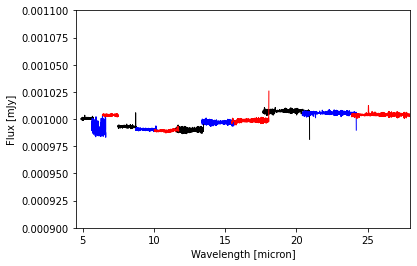

In [5]:
for j in range(0,6):
    ip.main(band_chan[j],[1,2],1,1e-7)
    
    result=AssignWcsStep.call('mock'+band_chan[j]+'-0.fits',save_results=True)
    result=AssignWcsStep.call('mock'+band_chan[j]+'-1.fits',save_results=True)
    
    wtype=3
    band=indiv1[j]
    filenames='mock'+band_chan[j]+'-0_assignwcsstep.fits','mock'+band_chan[j]+'-1_assignwcsstep.fits'
    modshep.setcube(filenames, band, wtype)
    
    band=indiv2[j]
    filenames='mock'+band_chan[j]+'-0_assignwcsstep.fits','mock'+band_chan[j]+'-1_assignwcsstep.fits'
    modshep.setcube(filenames, band, wtype)
        
    image1,header1=fits.getdata('pystack/pycube'+indiv1[j]+'.fits',header=True)
    
    num_x1=header1["NAXIS2"]
    num_y1=header1["NAXIS1"]
    num_chan1=header1["NAXIS3"]
    start_wavelength1=header1["CRVAL3"]
    step_wavelength1=header1["CDELT3"]
    pix_size1=header1["CD2_2"]
    
    a1=[0.0]*num_chan1
    for i in range(0,num_chan1):
        for m in range(0,num_x1):
            for n in range(0,num_y1):
                a1[i]=image1[i,m,n]+a1[i]    

    d1=[0.0]*num_chan1
    d1[0]=start_wavelength1
    for i in range(1,num_chan1):
        d1[i]=d1[i-1]+step_wavelength1
        
    for i in range(0,num_chan1):
        a1[i]=(a1[i]*(pix_size1*3600)*(pix_size1*3600)*(10**6))/(4.25*10**10)
    
    image2,header2=fits.getdata('pystack/pycube'+indiv2[j]+'.fits',header=True)
    
    num_x2=header2["NAXIS2"]
    num_y2=header2["NAXIS1"]
    num_chan2=header2["NAXIS3"]
    start_wavelength2=header2["CRVAL3"]
    step_wavelength2=header2["CDELT3"]
    pix_size2=header2["CD2_2"]
    
    a2=[0.0]*num_chan2
    for i in range(0,num_chan2):
        for m in range(0,num_x2):
            for n in range(0,num_y2):
                a2[i]=image2[i,m,n]+a2[i]   
                
    d2=[0.0]*num_chan2
    d2[0]=start_wavelength2
    for i in range(1,num_chan2):
        d2[i]=d2[i-1]+step_wavelength2                
                
    for i in range(0,num_chan2):
        a2[i]=(a2[i]*(pix_size2*3600)*(pix_size2*3600)*(10**6))/(4.25*10**10)
        
        
    plt.plot(d1,a1,'-', color=plot_color[j], lw=1)
    plt.plot(d2,a2,'-', color=plot_color[j], lw=1)
    plt.xlim(4.5,28)
    plt.ylim(0.0009,0.0011) 
    plt.xlabel('Wavelength [micron]')
    plt.ylabel('Flux [mJy]')
    
plt.savefig('point_source_flux_conservation_modshep_all.pdf')

#### Use WCS corrected mock files to test cube build.
#### cube_testing.json file looks like the following:

#### {"asn_rule": "Asn_MIRIFU_Dither", 
#### "targname": "MYTarget", 
#### "asn_pool": "jw00024_001_01_pool", 
#### "program": "0001",
#### "asn_type":"dither",
#### "asn_id": "a3001",
#### "target": "1",
#### "products": [ {"name": "det_image", 
#### "members": [ {"exptype": "SCIENCE", "expname": "mock12A-0_assignwcsstep.fits"}, 
#### {"exptype": "SCIENCE", "expname": "mock12A-1_assignwcsstep.fits"} ] } ] }

#### result=CubeBuildStep.call('cube_testing.json',save_results=True) (this will run each channel/band individually)
#### result=CubeBuildStep.call('cube_testing.json',save_results=True, --output_type=multi) (this will make one cube as the final output)

In [6]:
#The output should be 12 files: det_image_ch1-short_s3d.fits, det_image_ch1-medium_s3d.fits, etc.
result=CubeBuildStep.call('cube_testing.json',save_results=True)

2021-02-04 21:54:04,620 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.


2021-02-04 21:54:05,185 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep running with args ('cube_testing.json',).


2021-02-04 21:54:05,187 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'channel': 'all', 'band': 'all', 'grating': 'all', 'filter': 'all', 'output_type': 'band', 'scale1': 0.0, 'scale2': 0.0, 'scalew': 0.0, 'weighting': 'emsm', 'coord_system': 'skyalign', 'rois': 0.0, 'roiw': 0.0, 'weight_power': 2.0, 'wavemin': None, 'wavemax': None, 'single': False, 'xdebug': None, 'ydebug': None, 'zdebug': None, 'skip_dqflagging': False}


2021-02-04 21:54:05,188 - stpipe.CubeBuildStep - INFO - Starting IFU Cube Building Step


2021-02-04 21:54:05,188 - stpipe.CubeBuildStep - INFO - Input interpolation: pointcloud


2021-02-04 21:54:05,188 - stpipe.CubeBuildStep - INFO - Coordinate system to use: skyalign


2021-02-04 21:54:05,189 - stpipe.CubeBuildStep - INFO - Weighting method for point cloud: emsm


2021-02-04 21:54:05,189 - stpipe.CubeBuildStep - INFO - Power weighting distance: 2.0


2021-02-04 21:54:16,832 - stpipe.CubeBuildStep - INFO - The desired cubes cover the MIRI Channels: ['1', '1', '1', '2', '2', '2', '3', '3', '3', '4', '4', '4']


2021-02-04 21:54:16,833 - stpipe.CubeBuildStep - INFO - The desired cubes cover the MIRI subchannels: ['short', 'medium', 'long', 'short', 'medium', 'long', 'short', 'medium', 'long', 'short', 'medium', 'long']


2021-02-04 21:54:16,834 - stpipe.CubeBuildStep - INFO - Reading cube parameter file /grp/crds/cache/references/jwst/jwst_miri_cubepar_0004.fits


2021-02-04 21:54:17,782 - stpipe.CubeBuildStep - INFO - Output Cubes are single channel, single sub-channel IFU Cubes


2021-02-04 21:54:17,783 - stpipe.CubeBuildStep - INFO - Number of IFU cubes produced by this run = 12


2021-02-04 21:54:18,129 - stpipe.CubeBuildStep - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/geometry.py:203: RuntimeWarning: invalid value encountered in remainder
  lon = np.mod(lon, 360.0 * u.deg if nquant else 360.0)



2021-02-04 21:54:18,467 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 21:54:18,468 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 21:54:18,469 - stpipe.CubeBuildStep - INFO - Axis 1    47  24.00  44.99998961   0.13000000  -3.05499989   3.05499989


2021-02-04 21:54:18,469 - stpipe.CubeBuildStep - INFO - Axis 2    39  20.00  -0.00001393   0.13000000  -2.53499991   2.53499991


2021-02-04 21:54:18,469 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 21:54:18,469 - stpipe.CubeBuildStep - INFO - Axis 3   850   1.00   4.89049987   0.00100000   4.88999987   5.73999991


2021-02-04 21:54:18,470 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 1, short


2021-02-04 21:54:18,470 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch1-short_s3d.fits


2021-02-04 21:54:18,850 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5864 with wavelength below 4.887499866541475


2021-02-04 21:54:18,851 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10865 with wavelength above 5.74249990680255


2021-02-04 21:55:23,647 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 39.1 s


2021-02-04 21:55:24,035 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5864 with wavelength below 4.887499866541475


2021-02-04 21:55:24,037 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10865 with wavelength above 5.74249990680255


2021-02-04 21:56:27,953 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 38.8 s


2021-02-04 21:56:28,036 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 21:56:28,036 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 21:56:28,037 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.1 s


2021-02-04 21:56:30,085 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 21:56:30,086 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 21:56:30,086 - stpipe.CubeBuildStep - INFO - Axis 1    47  24.00  44.99999829   0.13000000  -3.05499989   3.05499989


2021-02-04 21:56:30,087 - stpipe.CubeBuildStep - INFO - Axis 2    39  20.00  -0.00005758   0.13000000  -2.53499991   2.53499991


2021-02-04 21:56:30,087 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 21:56:30,087 - stpipe.CubeBuildStep - INFO - Axis 3   980   1.00   5.64049987   0.00100000   5.63999987   6.61999991


2021-02-04 21:56:30,088 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 1, medium


2021-02-04 21:56:30,088 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch1-medium_s3d.fits


2021-02-04 21:56:30,442 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5760 with wavelength below 5.637499866541475


2021-02-04 21:56:30,443 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10519 with wavelength above 6.622499912977219


2021-02-04 21:57:38,187 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 38.5 s


2021-02-04 21:57:38,563 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5760 with wavelength below 5.637499866541475


2021-02-04 21:57:38,564 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10519 with wavelength above 6.622499912977219


2021-02-04 21:58:47,052 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 40.2 s


2021-02-04 21:58:47,126 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 21:58:47,126 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 21:58:47,127 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.1 s


2021-02-04 21:58:49,731 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 21:58:49,732 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 21:58:49,733 - stpipe.CubeBuildStep - INFO - Axis 1    45  23.00  44.99999712   0.13000000  -2.92499989   2.92499989


2021-02-04 21:58:49,733 - stpipe.CubeBuildStep - INFO - Axis 2    39  20.00   0.00002680   0.13000000  -2.53499991   2.53499991


2021-02-04 21:58:49,733 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 21:58:49,734 - stpipe.CubeBuildStep - INFO - Axis 3  1091   1.00   6.42050008   0.00100000   6.42000008   7.51100013


2021-02-04 21:58:49,734 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 1, long


2021-02-04 21:58:49,734 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch1-long_s3d.fits


2021-02-04 21:58:50,073 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7150 with wavelength below 6.417500076349825


2021-02-04 21:58:50,074 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10399 with wavelength above 7.513500128057785


2021-02-04 21:59:59,744 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 38.3 s


2021-02-04 22:00:00,117 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7150 with wavelength below 6.417500076349825


2021-02-04 22:00:00,118 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 10399 with wavelength above 7.513500128057785


2021-02-04 22:01:09,069 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 38.4 s


2021-02-04 22:01:09,154 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 22:01:09,155 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 22:01:09,155 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.1 s


2021-02-04 22:01:11,106 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 22:01:11,107 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 22:01:11,108 - stpipe.CubeBuildStep - INFO - Axis 1    41  21.00  45.00000773   0.17000000  -3.48500004   3.48500004


2021-02-04 22:01:11,108 - stpipe.CubeBuildStep - INFO - Axis 2    37  19.00  -0.00011236   0.17000000  -3.14500003   3.14500003


2021-02-04 22:01:11,108 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 22:01:11,109 - stpipe.CubeBuildStep - INFO - Axis 3   631   1.00   7.49099977   0.00200000   7.48999977   8.75199983


2021-02-04 22:01:11,109 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 2, short


2021-02-04 22:01:11,110 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch2-short_s3d.fits


2021-02-04 22:01:11,430 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 8363 with wavelength below 7.484999771229923


2021-02-04 22:01:11,430 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12444 with wavelength above 8.756999830948189


2021-02-04 22:01:57,609 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 30.5 s


2021-02-04 22:01:57,959 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 8363 with wavelength below 7.484999771229923


2021-02-04 22:01:57,960 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12444 with wavelength above 8.756999830948189


2021-02-04 22:02:43,913 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 30.7 s


2021-02-04 22:02:43,955 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 22:02:43,955 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 22:02:43,956 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.0 s


2021-02-04 22:02:46,597 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 22:02:46,598 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 22:02:46,599 - stpipe.CubeBuildStep - INFO - Axis 1    41  21.00  44.99997868   0.17000000  -3.48500004   3.48500004


2021-02-04 22:02:46,599 - stpipe.CubeBuildStep - INFO - Axis 2    37  19.00  -0.00018650   0.17000000  -3.14500003   3.14500003


2021-02-04 22:02:46,599 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 22:02:46,600 - stpipe.CubeBuildStep - INFO - Axis 3   745   1.00   8.72100027   0.00200000   8.72000027  10.21000034


2021-02-04 22:02:46,600 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 2, medium


2021-02-04 22:02:46,600 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch2-medium_s3d.fits


2021-02-04 22:02:46,931 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7081 with wavelength below 8.715000267140567


2021-02-04 22:02:46,932 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 13388 with wavelength above 10.215000337688252


2021-02-04 22:03:41,457 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 34.4 s


2021-02-04 22:03:41,794 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7081 with wavelength below 8.715000267140567


2021-02-04 22:03:41,795 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 13388 with wavelength above 10.215000337688252


2021-02-04 22:04:36,358 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 34.8 s


2021-02-04 22:04:36,405 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 22:04:36,406 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 22:04:36,407 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.0 s


2021-02-04 22:04:38,434 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 22:04:38,435 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 22:04:38,435 - stpipe.CubeBuildStep - INFO - Axis 1    41  21.00  45.00003541   0.17000000  -3.48500004   3.48500004


2021-02-04 22:04:38,436 - stpipe.CubeBuildStep - INFO - Axis 2    37  19.00  -0.00016185   0.17000000  -3.14500003   3.14500003


2021-02-04 22:04:38,436 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 22:04:38,436 - stpipe.CubeBuildStep - INFO - Axis 3   855   1.00  10.03099973   0.00200000  10.02999973  11.73999981


2021-02-04 22:04:38,437 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 2, long


2021-02-04 22:04:38,438 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch2-long_s3d.fits


2021-02-04 22:04:38,797 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7678 with wavelength below 10.02499973308295


2021-02-04 22:04:38,798 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 11501 with wavelength above 11.744999814080074


2021-02-04 22:05:39,063 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 38.5 s


2021-02-04 22:05:39,442 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 7678 with wavelength below 10.02499973308295


2021-02-04 22:05:39,443 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 11501 with wavelength above 11.744999814080074


2021-02-04 22:06:38,814 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 38.2 s


2021-02-04 22:06:38,876 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 22:06:38,877 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 22:06:38,878 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.1 s


2021-02-04 22:06:41,739 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 22:06:41,740 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 22:06:41,741 - stpipe.CubeBuildStep - INFO - Axis 1    47  24.00  44.99983061   0.20000000  -4.70000007   4.70000007


2021-02-04 22:06:41,741 - stpipe.CubeBuildStep - INFO - Axis 2    39  20.00  -0.00005064   0.20000000  -3.90000006   3.90000006


2021-02-04 22:06:41,742 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 22:06:41,743 - stpipe.CubeBuildStep - INFO - Axis 3   647   1.00  11.53149973   0.00300000  11.52999973  13.47099975


2021-02-04 22:06:41,743 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 3, short


2021-02-04 22:06:41,743 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch3-short_s3d.fits


2021-02-04 22:06:42,098 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6906 with wavelength below 11.522999732755125


2021-02-04 22:06:42,098 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12522 with wavelength above 13.477999750059098


2021-02-04 22:07:43,311 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 38.5 s


2021-02-04 22:07:43,694 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6906 with wavelength below 11.522999732755125


2021-02-04 22:07:43,695 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12522 with wavelength above 13.477999750059098


2021-02-04 22:08:45,200 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 39.4 s


2021-02-04 22:08:45,252 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 22:08:45,253 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 22:08:45,253 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.1 s


2021-02-04 22:08:47,204 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 22:08:47,206 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 22:08:47,206 - stpipe.CubeBuildStep - INFO - Axis 1    45  23.00  44.99990298   0.20000000  -4.50000007   4.50000007


2021-02-04 22:08:47,207 - stpipe.CubeBuildStep - INFO - Axis 2    39  20.00  -0.00010378   0.20000000  -3.90000006   3.90000006


2021-02-04 22:08:47,207 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 22:08:47,208 - stpipe.CubeBuildStep - INFO - Axis 3   754   1.00  13.37149989   0.00300000  13.36999989  15.63199991


2021-02-04 22:08:47,209 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 3, medium


2021-02-04 22:08:47,209 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch3-medium_s3d.fits


2021-02-04 22:08:47,541 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6213 with wavelength below 13.362999885343015


2021-02-04 22:08:47,542 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 11885 with wavelength above 15.638999905437231


2021-02-04 22:09:57,340 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 44.5 s


2021-02-04 22:09:57,701 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6213 with wavelength below 13.362999885343015


2021-02-04 22:09:57,702 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 11885 with wavelength above 15.638999905437231


2021-02-04 22:11:07,327 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 44.8 s


2021-02-04 22:11:07,385 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 22:11:07,386 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 22:11:07,387 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.1 s


2021-02-04 22:11:09,466 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 22:11:09,467 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 22:11:09,468 - stpipe.CubeBuildStep - INFO - Axis 1    45  23.00  44.99987711   0.20000000  -4.50000007   4.50000007


2021-02-04 22:11:09,468 - stpipe.CubeBuildStep - INFO - Axis 2    39  20.00  -0.00010090   0.20000000  -3.90000006   3.90000006


2021-02-04 22:11:09,468 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 22:11:09,469 - stpipe.CubeBuildStep - INFO - Axis 3   870   1.00  15.44149958   0.00300000  15.43999958  18.04999960


2021-02-04 22:11:09,469 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 3, long


2021-02-04 22:11:09,469 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch3-long_s3d.fits


2021-02-04 22:11:09,809 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6375 with wavelength below 15.432999580167234


2021-02-04 22:11:09,810 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12083 with wavelength above 18.056999603286386


2021-02-04 22:12:29,937 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 51.5 s


2021-02-04 22:12:30,308 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6375 with wavelength below 15.432999580167234


2021-02-04 22:12:30,309 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 12083 with wavelength above 18.056999603286386


2021-02-04 22:13:49,522 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 50.8 s


2021-02-04 22:13:49,590 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 22:13:49,590 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 22:13:49,591 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.1 s


2021-02-04 22:13:52,312 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 22:13:52,313 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 22:13:52,314 - stpipe.CubeBuildStep - INFO - Axis 1    33  17.00  45.00007295   0.34999999  -5.77499990   5.77499990


2021-02-04 22:13:52,314 - stpipe.CubeBuildStep - INFO - Axis 2    27  14.00  -0.00020009   0.34999999  -4.72499992   4.72499992


2021-02-04 22:13:52,315 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 22:13:52,315 - stpipe.CubeBuildStep - INFO - Axis 3   544   1.00  17.66299985   0.00600000  17.65999985  20.92399988


2021-02-04 22:13:52,316 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 4, short


2021-02-04 22:13:52,316 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch4-short_s3d.fits


2021-02-04 22:13:52,608 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 4801 with wavelength below 17.645999846979976


2021-02-04 22:13:52,609 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5823 with wavelength above 20.937999876216054


2021-02-04 22:14:31,390 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 29.3 s


2021-02-04 22:14:31,703 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 4801 with wavelength below 17.645999846979976


2021-02-04 22:14:31,704 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5823 with wavelength above 20.937999876216054


2021-02-04 22:15:10,052 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 29.0 s


2021-02-04 22:15:10,070 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 22:15:10,071 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 22:15:10,071 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.0 s


2021-02-04 22:15:11,958 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 22:15:11,959 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 22:15:11,959 - stpipe.CubeBuildStep - INFO - Axis 1    31  16.00  45.00007259   0.34999999  -5.42499991   5.42499991


2021-02-04 22:15:11,960 - stpipe.CubeBuildStep - INFO - Axis 2    27  14.00  -0.00018561   0.34999999  -4.72499992   4.72499992


2021-02-04 22:15:11,960 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 22:15:11,961 - stpipe.CubeBuildStep - INFO - Axis 3   631   1.00  20.42300008   0.00600000  20.42000008  24.20600011


2021-02-04 22:15:11,961 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 4, medium


2021-02-04 22:15:11,961 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch4-medium_s3d.fits


2021-02-04 22:15:12,244 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 3753 with wavelength below 20.40600007586181


2021-02-04 22:15:12,244 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5807 with wavelength above 24.220000109635293


2021-02-04 22:15:55,777 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 32.8 s


2021-02-04 22:15:56,102 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 3753 with wavelength below 20.40600007586181


2021-02-04 22:15:56,103 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 5807 with wavelength above 24.220000109635293


2021-02-04 22:16:40,161 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 33.5 s


2021-02-04 22:16:40,184 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 22:16:40,185 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 22:16:40,185 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.0 s


2021-02-04 22:16:42,853 - stpipe.CubeBuildStep - INFO - Cube Geometry:


2021-02-04 22:16:42,854 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)


2021-02-04 22:16:42,855 - stpipe.CubeBuildStep - INFO - Axis 1    31  16.00  45.00006953   0.34999999  -5.42499991   5.42499991


2021-02-04 22:16:42,856 - stpipe.CubeBuildStep - INFO - Axis 2    27  14.00  -0.00015628   0.34999999  -4.72499992   4.72499992


2021-02-04 22:16:42,856 - stpipe.CubeBuildStep - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)


2021-02-04 22:16:42,856 - stpipe.CubeBuildStep - INFO - Axis 3   737   1.00  23.89299939   0.00600000  23.88999939  28.31199943


2021-02-04 22:16:42,857 - stpipe.CubeBuildStep - INFO - Cube covers channel, subchannel: 4, long


2021-02-04 22:16:42,858 - stpipe.CubeBuildStep - INFO - Output Name: det_image_ch4-long_s3d.fits


2021-02-04 22:16:43,171 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 4329 with wavelength below 23.875999389216304


2021-02-04 22:16:43,172 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6241 with wavelength above 28.325999428518116


2021-02-04 22:17:33,116 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 37.6 s


2021-02-04 22:17:33,415 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 4329 with wavelength below 23.875999389216304


2021-02-04 22:17:33,415 - stpipe.CubeBuildStep - INFO - # of detector pixels not mapped to output plane: 6241 with wavelength above 28.325999428518116


2021-02-04 22:18:23,033 - stpipe.CubeBuildStep - INFO - Time to match file to ifucube = 37.6 s


2021-02-04 22:18:23,057 - stpipe.CubeBuildStep - INFO - Average # of holes/wavelength plane is < 1


2021-02-04 22:18:23,058 - stpipe.CubeBuildStep - INFO - Total # of holes for IFU cube is : 0


2021-02-04 22:18:23,058 - stpipe.CubeBuildStep - INFO - Time to find Cube Flux = 0.0 s


2021-02-04 22:18:24,452 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999159056 -0.000700041 44.999159056 0.000672181 45.000820167 0.000672181 45.000820167 -0.000700041


2021-02-04 22:18:24,454 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999167732 -0.000743688 44.999167732 0.000628535 45.000828843 0.000628535 45.000828843 -0.000743688


2021-02-04 22:18:24,456 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999202676 -0.000659312 44.999202676 0.000712910 45.000791565 0.000712910 45.000791565 -0.000659312


2021-02-04 22:18:24,458 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999063284 -0.000962359 44.999063284 0.000737641 45.000952173 0.000737641 45.000952173 -0.000962359


2021-02-04 22:18:24,460 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999034240 -0.001036502 44.999034240 0.000663498 45.000923129 0.000663498 45.000923129 -0.001036502


2021-02-04 22:18:24,461 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.999090969 -0.001011846 44.999090969 0.000688154 45.000979858 0.000688154 45.000979858 -0.001011846


2021-02-04 22:18:24,463 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998552834 -0.001106196 44.998552834 0.001004915 45.001108390 0.001004915 45.001108390 -0.001106196


2021-02-04 22:18:24,465 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998680759 -0.001159337 44.998680759 0.000951774 45.001125203 0.000951774 45.001125203 -0.001159337


2021-02-04 22:18:24,467 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998654887 -0.001156454 44.998654887 0.000954657 45.001099332 0.000954657 45.001099332 -0.001156454


2021-02-04 22:18:24,469 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998517394 -0.001463977 44.998517394 0.001063801 45.001628505 0.001063801 45.001628505 -0.001463977


2021-02-04 22:18:24,471 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998614255 -0.001449501 44.998614255 0.001078277 45.001530921 0.001078277 45.001530921 -0.001449501


2021-02-04 22:18:24,472 - stpipe.CubeBuildStep - INFO - Update S_REGION to POLYGON ICRS  44.998611198 -0.001420170 44.998611198 0.001107608 45.001527865 0.001107608 45.001527865 -0.001420170


2021-02-04 22:18:24,835 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch1-short_s3d.fits


2021-02-04 22:18:25,190 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch1-medium_s3d.fits


2021-02-04 22:18:25,550 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch1-long_s3d.fits


2021-02-04 22:18:25,901 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch2-short_s3d.fits


2021-02-04 22:18:26,247 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch2-medium_s3d.fits


2021-02-04 22:18:26,596 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch2-long_s3d.fits


2021-02-04 22:18:26,944 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch3-short_s3d.fits


2021-02-04 22:18:27,293 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch3-medium_s3d.fits


2021-02-04 22:18:27,644 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch3-long_s3d.fits


2021-02-04 22:18:27,981 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch4-short_s3d.fits


2021-02-04 22:18:28,316 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch4-medium_s3d.fits


2021-02-04 22:18:28,649 - stpipe.CubeBuildStep - INFO - Saved model in det_image_ch4-long_s3d.fits


2021-02-04 22:18:28,650 - stpipe.CubeBuildStep - INFO - Step CubeBuildStep done


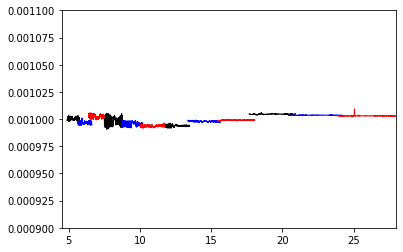

In [7]:
#Define band and channels
band_chan=['ch1-short','ch2-short','ch3-short','ch4-short']

for j in range(0,4):
    image3,header3=fits.getdata('det_image_'+band_chan[j]+'_s3d.fits',header=True)

    num_x3=header3["NAXIS2"]
    num_y3=header3["NAXIS1"]
    num_chan3=header3["NAXIS3"]
    start_wavelength3=header3["CRVAL3"]
    step_wavelength3=header3["CDELT3"]
    pix_size3=header3["CDELT1"]

    a3=[0.0]*num_chan3
    for i in range(0,num_chan3):
        for m in range(0,num_x3):
            for n in range(0,num_y3):
                a3[i]=image3[i,m,n]+a3[i]
            
    d3=[0.0]*num_chan3
    d3[0]=start_wavelength3
    for i in range(1,num_chan3):
        d3[i]=d3[i-1]+step_wavelength3
    
    for i in range(0,num_chan3):
        a3[i]=(a3[i]*(pix_size3*3600)*(pix_size3*3600)*(10**6))/(4.25*10**10)

    plt.plot(d3,a3,'-', color='black', lw=1)
    plt.xlim(4.5,28)
    plt.ylim(0.0009,0.0011) 

#Define band and channels
band_chan=['ch1-medium','ch2-medium','ch3-medium','ch4-medium']

for j in range(0,4):
    image3,header3=fits.getdata('det_image_'+band_chan[j]+'_s3d.fits',header=True)

    num_x3=header3["NAXIS2"]
    num_y3=header3["NAXIS1"]
    num_chan3=header3["NAXIS3"]
    start_wavelength3=header3["CRVAL3"]
    step_wavelength3=header3["CDELT3"]
    pix_size3=header3["CDELT1"]

    a3=[0.0]*num_chan3
    for i in range(0,num_chan3):
        for m in range(0,num_x3):
            for n in range(0,num_y3):
                a3[i]=image3[i,m,n]+a3[i]
            
    d3=[0.0]*num_chan3
    d3[0]=start_wavelength3
    for i in range(1,num_chan3):
        d3[i]=d3[i-1]+step_wavelength3
    
    for i in range(0,num_chan3):
        a3[i]=(a3[i]*(pix_size3*3600)*(pix_size3*3600)*(10**6))/(4.25*10**10)

    plt.plot(d3,a3,'-', color='blue', lw=1)
    plt.xlim(4.5,28)
    plt.ylim(0.0009,0.0011) 
    
#Define band and channels
band_chan=['ch1-long','ch2-long','ch3-long','ch4-long']

for j in range(0,4):
    image3,header3=fits.getdata('det_image_'+band_chan[j]+'_s3d.fits',header=True)

    num_x3=header3["NAXIS2"]
    num_y3=header3["NAXIS1"]
    num_chan3=header3["NAXIS3"]
    start_wavelength3=header3["CRVAL3"]
    step_wavelength3=header3["CDELT3"]
    pix_size3=header3["CDELT1"]

    a3=[0.0]*num_chan3
    for i in range(0,num_chan3):
        for m in range(0,num_x3):
            for n in range(0,num_y3):
                a3[i]=image3[i,m,n]+a3[i]
            
    d3=[0.0]*num_chan3
    d3[0]=start_wavelength3
    for i in range(1,num_chan3):
        d3[i]=d3[i-1]+step_wavelength3
    
    for i in range(0,num_chan3):
        a3[i]=(a3[i]*(pix_size3*3600)*(pix_size3*3600)*(10**6))/(4.25*10**10)

    plt.plot(d3,a3,'-', color='red', lw=1)
    plt.xlim(4.5,28)
    plt.ylim(0.0009,0.0011)     

#### Check the output of flat point source using Extract 1D

In [8]:
#Do Band A things
band_chan=['ch1-short','ch2-short','ch3-short','ch4-short']
for i in range(0,4):
    temppath1='det_image_'+band_chan[i]+'_s3d.fits'
    print(temppath1)
    result=Extract1dStep.call(temppath1) 
    result.save(band_chan[i]+"_output_file_from_extract1d.fits")
    
#Do Band B things
band_chan=['ch1-medium','ch2-medium','ch3-medium','ch4-medium']
for i in range(0,4):
    temppath1='det_image_'+band_chan[i]+'_s3d.fits'
    result=Extract1dStep.call(temppath1) 
    result.save(band_chan[i]+"_output_file_from_extract1d.fits")
    
#Do Band C things
band_chan=['ch1-long','ch2-long','ch3-long','ch4-long']
for i in range(0,4):
    temppath1='det_image_'+band_chan[i]+'_s3d.fits'
    result=Extract1dStep.call(temppath1) 
    result.save(band_chan[i]+"_output_file_from_extract1d.fits")
    

2021-02-04 22:18:51,610 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


det_image_ch1-short_s3d.fits


2021-02-04 22:18:52,592 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch1-short_s3d.fits',).


2021-02-04 22:18:52,594 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:18:52,746 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:18:52,749 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:18:53,765 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:18:53,766 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:18:53,767 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:18:55,232 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2021-02-04 22:18:55,426 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


det_image_ch2-short_s3d.fits


2021-02-04 22:18:56,349 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch2-short_s3d.fits',).


2021-02-04 22:18:56,352 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:18:56,491 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:18:56,493 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:18:57,632 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:18:57,633 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:18:57,634 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:18:58,633 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2021-02-04 22:18:58,826 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


det_image_ch3-short_s3d.fits


2021-02-04 22:18:58,909 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch3-short_s3d.fits',).


2021-02-04 22:18:58,910 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:18:59,050 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:18:59,053 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:19:00,205 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:19:00,206 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:19:00,207 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:19:01,307 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2021-02-04 22:19:01,493 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


det_image_ch4-short_s3d.fits


2021-02-04 22:19:01,576 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch4-short_s3d.fits',).


2021-02-04 22:19:01,578 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:19:01,711 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:19:01,713 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:19:02,851 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:19:02,852 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:19:02,852 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:19:03,598 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2021-02-04 22:19:03,796 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2021-02-04 22:19:03,876 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch1-medium_s3d.fits',).


2021-02-04 22:19:03,877 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:19:04,020 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:19:04,022 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:19:05,162 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:19:05,163 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:19:05,164 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:19:06,797 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2021-02-04 22:19:06,987 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2021-02-04 22:19:07,065 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch2-medium_s3d.fits',).


2021-02-04 22:19:07,066 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:19:07,204 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:19:07,206 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:19:08,368 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:19:08,369 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:19:08,370 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:19:09,537 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2021-02-04 22:19:09,724 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2021-02-04 22:19:09,804 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch3-medium_s3d.fits',).


2021-02-04 22:19:09,806 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:19:09,943 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:19:09,946 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:19:11,079 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:19:11,080 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:19:11,081 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:19:12,323 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2021-02-04 22:19:12,507 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2021-02-04 22:19:12,583 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch4-medium_s3d.fits',).


2021-02-04 22:19:12,585 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:19:12,717 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:19:12,720 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:19:13,858 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:19:13,859 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:19:13,860 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:19:14,707 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2021-02-04 22:19:14,901 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2021-02-04 22:19:14,980 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch1-long_s3d.fits',).


2021-02-04 22:19:14,982 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:19:15,125 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:19:15,128 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:19:16,275 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:19:16,277 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:19:16,277 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:19:18,115 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2021-02-04 22:19:18,307 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2021-02-04 22:19:18,393 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch2-long_s3d.fits',).


2021-02-04 22:19:18,395 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:19:18,535 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:19:18,538 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:19:19,681 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:19:19,682 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:19:19,682 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:19:21,047 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2021-02-04 22:19:21,239 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2021-02-04 22:19:21,323 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch3-long_s3d.fits',).


2021-02-04 22:19:21,324 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:19:21,465 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:19:21,468 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:19:22,605 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:19:22,606 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:19:22,606 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:19:24,042 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2021-02-04 22:19:24,231 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2021-02-04 22:19:24,313 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_ch4-long_s3d.fits',).


2021-02-04 22:19:24,315 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'apply_apcorr': True}


2021-02-04 22:19:24,451 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0001.asdf


2021-02-04 22:19:24,453 - stpipe.Extract1dStep - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0001.asdf


2021-02-04 22:19:25,619 - stpipe.Extract1dStep - INFO - Turning on source position correction for exp_type = MIR_MRS


2021-02-04 22:19:25,620 - stpipe.Extract1dStep - INFO - Setting use_source_posn to False for source type EXTENDED


2021-02-04 22:19:25,621 - stpipe.Extract1dStep - INFO - Source type = EXTENDED


2021-02-04 22:19:26,609 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


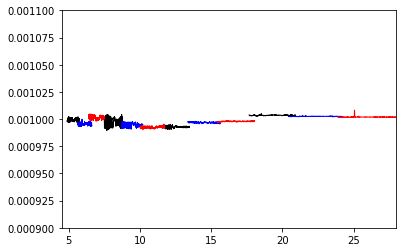

In [9]:
#Plot Band A
band_chan=['ch1-short','ch2-short','ch3-short','ch4-short']
for i in range(0,4):
    read_output1=fits.open(band_chan[i]+"_output_file_from_extract1d.fits")
    data1=Table.read(read_output1, hdu=1)
    flux1=data1['FLUX']
    wavelength1=data1['WAVELENGTH']
    plt.plot(wavelength1,flux1,'-', color='black', lw=1)

#Plot Band B
band_chan=['ch1-medium','ch2-medium','ch3-medium','ch4-medium']
for i in range(0,4):
    read_output1=fits.open(band_chan[i]+"_output_file_from_extract1d.fits")
    data1=Table.read(read_output1, hdu=1)
    flux1=data1['FLUX']
    wavelength1=data1['WAVELENGTH']
    plt.plot(wavelength1,flux1,'-', color='blue', lw=1)
    
#Plot Band C
band_chan=['ch1-long','ch2-long','ch3-long','ch4-long']
for i in range(0,4):
    read_output1=fits.open(band_chan[i]+"_output_file_from_extract1d.fits")
    data1=Table.read(read_output1, hdu=1)
    flux1=data1['FLUX']
    wavelength1=data1['WAVELENGTH']
    plt.plot(wavelength1,flux1,'-', color='red', lw=1)
    plt.xlim(4.5,28)
    plt.ylim(0.0009,0.0011) 

A successful test shows that the source is flat within 2%.